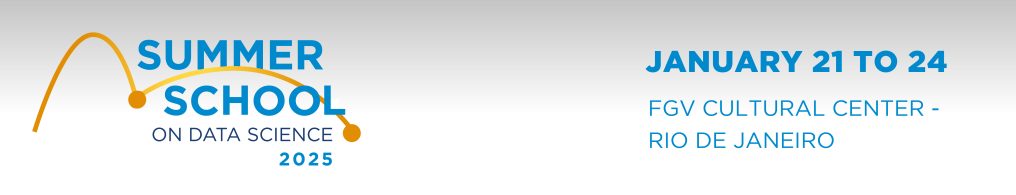

# FGV Summer School 2025
## Recommender Systems class 4 - Neighbourhood models

Diego Galeano, Ph.D.

$\color{green}{\text{Before starting}}$ let's run the following cell to have all the required libraries for this notebook.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import copy
import random
import scipy.io
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
#import pdb   #This library is used for debugging the code, otherwise it is not necessary.
              #You can simply enter pdb.set_trace() somewhere in your code for debugging purposes.

# If you want to have direct access to the datasets and codes you can clone the following github repository
! git clone https://github.com/saminehbagheri/Recommender-System.git
%cd Recommender-System


Cloning into 'Recommender-System'...
remote: Enumerating objects: 66, done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 66 (from 1)
Receiving objects: 100% (66/66), 347.53 KiB | 4.09 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/Recommender-System


# Read MovieLens dataset

In [2]:
mat = scipy.io.loadmat('ex8_movies.mat')
movie_names = pd.read_csv('movie_ids.txt',delimiter=';',header=None)[1]
R=mat['Y'].T # rating matrix
Rb=mat['R'] # binary version of the rating matrix
(n_users, n_movies) = R.shape

# User-based RecSys
Let us define the Pearson correlation between users as a similarity measure
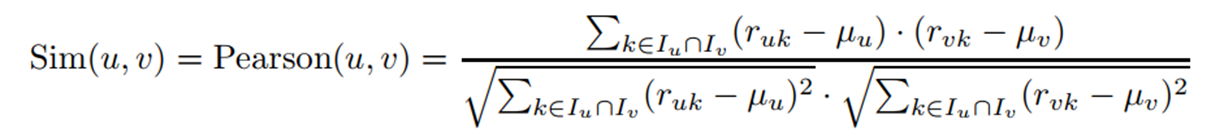

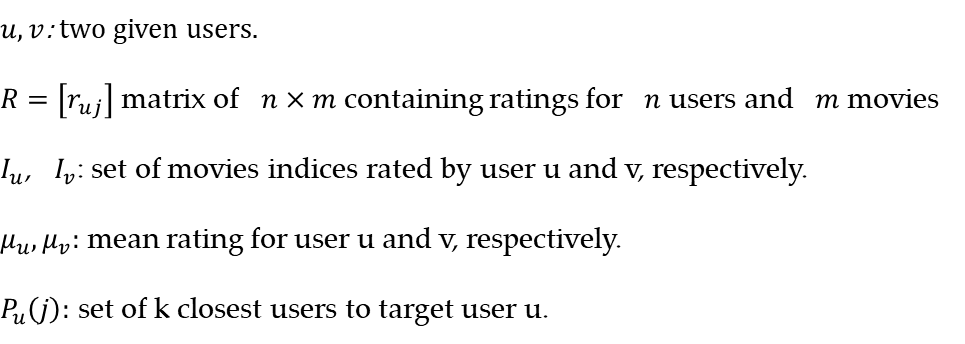

In [ ]:
def intersection(a, b):
    return list(set(a).intersection(b))

In [ ]:
R.shape

(943, 1682)

In [ ]:
df_Pearson = pd.DataFrame()
# define the indexes of users u and v
for u in range(n_users):
  for v in range(n_users):
    if u != v:
      # obtain the set of movies indices rated by users u and v
      I_u = np.where(R[u, :] > 0)[0]
      I_v = np.where(R[v, :] > 0)[0]

      # mean rating for users u and v
      mu_u = np.mean(R[u, I_u])
      mu_v = np.mean(R[v, I_v])

      # indexes of the set of items rated by users u and v
      I_uv = list(set(I_u) & set(I_v))

      if len(I_uv) > 0:
        numerator = np.sum((R[u, I_uv] - mu_u) *  (R[v, I_uv] - mu_v))
        denominator = np.sqrt(np.sum(np.power(R[u, I_uv] - mu_u, 2))) * np.sqrt(np.sum(np.power(R[v, I_uv] - mu_v, 2)))

        Pearson = numerator / float(denominator)

      else:
        Pearson = 0

      df_Pearson = pd.concat([df_Pearson, pd.DataFrame([{'user u': u, 'user v': v, 'Pearson_sim': Pearson, 'mu_u': mu_u, 'mu_v': mu_v}])])

  break # let's run this only for the 1st user in R.
df_Pearson = df_Pearson.reset_index(drop = True)

Text(0.5, 0, 'Pearson similarity')

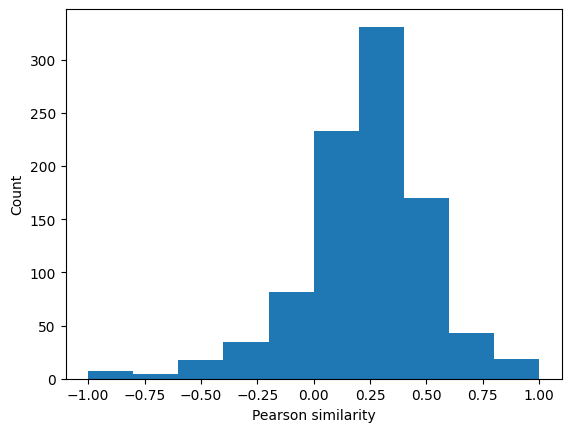

In [ ]:
plt.hist(df_Pearson['Pearson_sim'])
plt.ylabel('Count')
plt.xlabel('Pearson similarity')

Predict for user u and item j

In [ ]:
u = 0
j = 2

# Find the set of k-closest users to target user u that have specified ratings for item j.
k = 5
df_Pearson_ordered = df_Pearson.sort_values(['Pearson_sim'], ascending=False)

# We determine which users specified ratings for item j
idx_users_rated_itemj = np.where(R[:, v] > 0)

# We only keep those users
df_Pu = df_Pearson_ordered.head(k)
num = 0
den = 0

for v in set(df_Pu['user v']):
  dfv = df_Pu[df_Pu['user v'] == v]


  svj = R[v, j] - dfv['mu_v'].values[0]

  num += dfv['Pearson_sim'].values[0] * svj
  den += np.abs(dfv['Pearson_sim'].values[0])

Ruj_hat = df_Pu['mu_u'].values[0] + num / float(den)

print('Predicted rating (u, j) =', Ruj_hat)

Predicted rating (u, j) = 0.6311245527924534


# Item-based RecSys

# The SLIM model

In [52]:

def split_data(matrix):
    """Splits the data into training and test sets, selecting one random item per user for testing."""
    # evertything above 0 becomes 1, let's binarize matrix
    matrix = (matrix > 0).astype(int)
    train = matrix.copy()
    test = np.zeros_like(matrix)

    for user in range(matrix.shape[0]):
        items = np.where(matrix[user, :] > 0)[0]
        if len(items) > 0:
            test_item = np.random.choice(items)
            test[user, test_item] = train[user, test_item]
            train[user, test_item] = 0

    return train, test

def hit_rate(W, train, test, top_k=10):
    """Computes the hit rate by checking if the test items appear in the top-k recommendations for each user."""
    predictions = train @ W  # Compute item-based recommendations
    hits = 0

    for user in range(test.shape[0]):
        test_items = np.where(test[user, :] > 0)[0]
        if len(test_items) > 0:
            top_k_items = np.argsort(predictions[user, :])[-top_k:]
            hits += int(test_items[0] in top_k_items)

    return hits / test.shape[0]

In [56]:
def slim_projected_gradient_descent(A, beta=10, lambd=0.01, lr=0.0005, max_iter=30, tol=1e-3):
    """
    Learn the item-item weight matrix W using projected gradient descent.

    Parameters:
        A (numpy.ndarray): Input user-item data matrix (users x items)
        beta (float): Regularization parameter for Frobenius norm
        lambd (float): Regularization parameter for L1 norm
        lr (float): Learning rate for gradient descent
        max_iter (int): Maximum number of iterations
        tol (float): Convergence tolerance

    Returns:
        numpy.ndarray: Learned item-item weight matrix W
    """
    n_items = A.shape[1]
    W0 = np.random.rand(n_items, n_items) * 0.01  # Small random initialization
    np.fill_diagonal(W0, 0)  # Ensure diagonal is 0 initially
    sqrteps = np.sqrt(np.finfo(float).eps)
    delta = 0

    for iteration in range(max_iter):
        grad = -A.T @ (A - A @ W0) + beta * W0 + lambd * np.sign(W0)  # Compute gradient
        W = W0 - lr * grad  # Gradient descent update

        # Projection step
        W = np.maximum(W, 0)  # Clamp to non-negative values
        np.fill_diagonal(W, 0)  # Ensure diagonal remains zero

        # # Convergence check
        # if np.linalg.norm(grad, 'fro') < tol:
        #     break

        # Get norm of difference and max change in factors
        delta = np.amax(np.abs(W-W0))/(sqrteps + np.amax(np.abs(W0)))
        W0 = W.copy()

        # Compute loss
        if iteration % 10 == 0:
            loss = 0.5 * np.linalg.norm(A - A @ W, 'fro')**2 + 0.5 * beta * np.linalg.norm(W, 'fro')**2 + lambd * np.sum(np.abs(W))
            print(f"Iteration {iteration + 1}, Loss: {loss:.6f}")

        # Check for convergence
        if iteration > 1:
            if delta <= tol:
                print('Iter', iteration, 'delta', delta)
                break

    return W, delta

In [64]:
train, test = split_data(Rb)
W, delta = slim_projected_gradient_descent(train, beta=10, lambd=0.01, lr=0.00001, max_iter=100)
hr = hit_rate(W, train, test)
print(f"Training complete. Hit rate: {hr:.4f}")

Iteration 1, Loss: 105069.436330
Iteration 11, Loss: 37542.082370
Iteration 21, Loss: 32998.972032
Iteration 31, Loss: 31118.134972
Iteration 41, Loss: 29988.449825
Iteration 51, Loss: 29206.105668
Iteration 61, Loss: 28619.462025
Iteration 71, Loss: 28157.625124
Iteration 81, Loss: 27782.241254
Iteration 91, Loss: 27468.223633
Training complete. Hit rate: 0.1326


(array([8.66627e+05, 2.09760e+04, 1.40100e+03, 1.93000e+02, 3.80000e+01,
        1.00000e+01, 0.00000e+00, 0.00000e+00, 2.00000e+00, 2.00000e+00]),
 array([0.        , 0.00924994, 0.01849988, 0.02774982, 0.03699977,
        0.04624971, 0.05549965, 0.06474959, 0.07399953, 0.08324947,
        0.09249941]),
 <BarContainer object of 10 artists>)

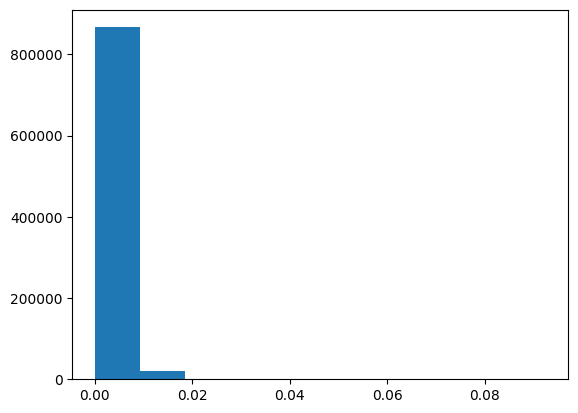

In [65]:
plt.hist(W.flatten())

In [47]:
W


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03364612, 0.03203505, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00408872, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])